<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/backprojection_2d_to_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: build up intuition for filtered back projection
- See Chapters 11 & 12 in `Hobbie, R. K., & Roth, B. J. (2007). Intermediate Physics for Medicine and Biology (4th ed.). New York, NY: Springer New York. http://doi.org/10.1007/978-0-387-49885-0`


# Theory

## 2D DFT
* A discrete function $f$, with components $f_{jk}$ is equal to a weighted sum of $\cos$ and $\sin$ parts, with the coefficients given below.
$$f_{jk} = \sum_{l,m = 0,...,N-1} C_{lm}\cos(\frac{2\pi(jl+km)}{N}) + S_{lm}(\sin\frac{2\pi(jl+km)}{N})$$

$$C_{lm} = \sum_{j,k = 0,...,N-1} f_{jk}\cos(\frac{2\pi(jl+km)}{N})$$

$$S_{lm} = \sum_{j,k = 0,...,N-1} f_{jk}\sin(\frac{2\pi(jl+km)}{N})$$

## Radon transform
* The integration of f along lines perpendicular to an axis tilted by $\theta$ is defined as:
$$F(\theta,x) = \int dy^\prime 
f(x=x^\prime\cos(\theta)-y^\prime\sin(\theta),
y=x^\prime\sin(\theta)+y^\prime\cos(\theta))$$

## Back projection
* The back projection $f_b$ of function $f$ is defined as:
$$f_{b}(x,y) = \int_0^\pi d\theta \ F(\theta,x^\prime)$$

## Filtered back projection
* We can reconstruct $f$ from the back projection of an intermediate function $g$, where $g$ is a function such that the convolution of projections (Radon transforms) $F(\theta,x)$ and $h(x,y) = 1/r$ is $G$, the Fourier transform of $g$

$$ f = g_b = g * h = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} dx^\prime dy^\prime
\frac{g(x^\prime,y^\prime)}{((x-x^\prime)^2 + (y-y^\prime)^2)^{1/2}}
$$

$$h(x) = 
\frac{k^2_{x \max}}{(2\pi)^2}
(2\text{sinc}(\xi) - \text{sinc}(\xi/2)) \
\text{; where }\xi = k^2_{x \max}x$$

$$h(k) = 0 \ ; \ k \text{ even}$$
$$h(k) = \frac{-N^2}{4\pi^2k^2} \ ; k \text{ odd}$$
$$h(k) = \frac{+N^2}{16} \ ; k=0 $$







# Example: Top Hat
- consider the top hat function (1 inside circle of radius a, 0 elsewhere)
$$f(x,y) = 1 \ \text{where } x^2 + y^2 < a^2$$
$$F(\theta,x^\prime) = \int_{x^2 + y^2 < a^2} dy^\prime 1 = 2\sqrt{a^2 - x^2} \ \text{where x^2 < a^2}$$
- this is a very simple example, since it is symetric in $\theta$, and so we only need to compute $F(\theta,x^\prime)$ at one angle ($\theta = 0$) to get $F$ at all angles.

$$H(x) = 
\frac{k^2_{x \max}}{(2\pi)^2}
(2\text{sinc}(\xi) - \text{sinc}(\xi/2)) \
\text{; where }\xi = k^2_{x \max}x$$

$$H(k) = 0 \ ; \ k \text{ even}$$
$$H(k) = \frac{-N^2}{4\pi^2k^2} \ ; k \text{ odd}$$
$$H(k) = \frac{+N^2}{16} \ ; k=0 $$

In [0]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

In [171]:
# calculate projection
a2=0.5**2
N=1000 # with N=100, can do back projection increments in one degree, but with larger N, need to do more back projections with finer theta increments
X = np.linspace(-1,1,N+1)
X

array([-1.   , -0.998, -0.996, ...,  0.996,  0.998,  1.   ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


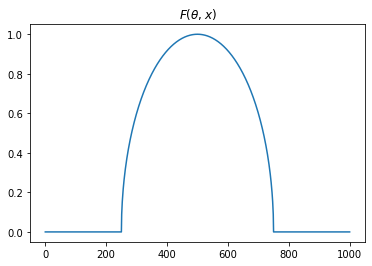

In [165]:
# calc F
domain = X**2 < a2
F = np.zeros_like(X)
F[domain] = 2*np.sqrt(a2-X**2)[domain]
pd.Series(F).plot(title=r'$F(\theta,x)$') # max 1 because 2*sqrt(a**2) = 2a

In [0]:
# h
def Hk(k,N=N):
  if k == 0:
    H = N**2/float(16)
  elif np.isclose(k % 2, 1) | np.isclose(-k % 2, 1): # k odd
    H=-N**2/float(4*(np.pi*k)**2)
  else:
    H=0
  return(H)
    

In [0]:
H = np.vectorize(Hk)(np.arange(-N/2,N/2,dtype=np.float32))

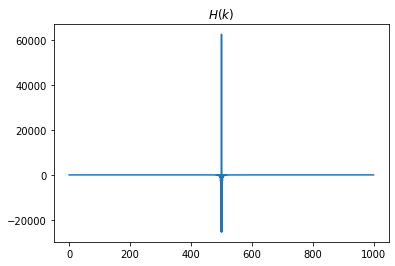

In [172]:
pd.Series(H).plot(title=r'$H(k)$') # first few terms very large

In [0]:
# convolve
def convolve(F,Hk):
  G = np.zeros_like(F)
  for i in range(F.shape[0]):
    for j in range(F.shape[0]):
      #if 0 <= i - j and i - j < H_idx_max:
      G[i]+=F[j]*Hk(i-j) # could precompute H, but then need to map out indeces
    G[i] /= F.shape[0]
  return(G)
G = convolve(F,Hk)
pd.Series(G).plot(title='F*H')

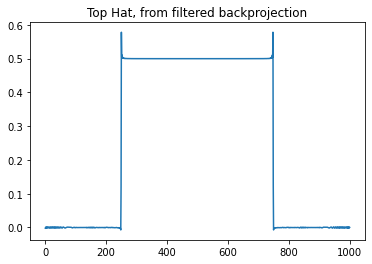

In [176]:
# back project
num_pj = 180*10
Image = np.zeros_like(X)

for j in np.linspace(0,180,num_pj): # degrees
  cj = np.cos(np.pi*j/180)
  #print(cj,)
  for i in range(X.shape[0]):
    x = N/2+(i+1 - N/2)*cj # coordinate
    l = np.ceil(x).astype(np.int32)
    xinterp = x-l
    
    if l <= 1: Image[i] += G[0] #unclear
    elif l >= N: Image[i] += G[-1]
    else:
      Image[i] += G[l-1] + xinterp*(G[l] - G[l-1]) # weights by how close to neighbouring points
    #print(x,l,xinterp,G[l-1],Image[l])
Image *= np.pi/num_pj
pd.Series(Image).plot(title='Top Hat function from filtered backprojection')

# Example: Gaussian, symmetric in x and y
- The 2D Gaussian is the same in a ring around the origin, so $x^2+y^2 = (x^\prime)^2 + (y^\prime)^2$, and the the integral over $y^\prime$ is easy to compute. It has no $\theta$ dependence.
$$F(\theta,x^\prime) = F(x^\prime) = \sqrt{\pi}e^{-(x^\prime)^2}$$


In [0]:
N=1000 # with N=100, can do back projection increments in one degree, but with larger N, need to do more back projections with finer theta increments
X = np.linspace(-4,4,N+1)

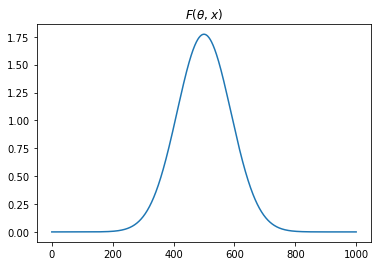

In [182]:
# calc F

F = np.zeros_like(X)
F = np.sqrt(np.pi)*np.exp(-X**2)
pd.Series(F).plot(title=r'$F(\theta,x)$') # max sqrt(pi)

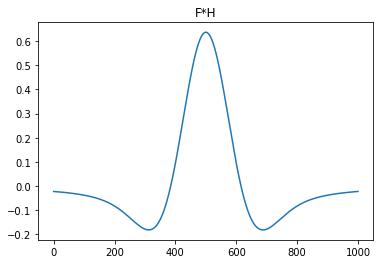

In [185]:
# convolve
G = convolve(F,Hk)
pd.Series(G).plot(title='F*H')

In [194]:
G.shape

(1001,)

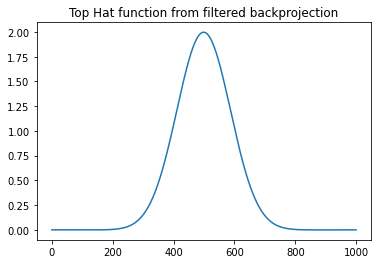

In [197]:
# back project
def back_project(G,num_pj,N):
  Image = np.zeros_like(G)

  for j in np.linspace(0,180,num_pj): # degrees
    cj = np.cos(np.pi*j/180)
    #print(cj,)
    for i in range(G.shape[0]):
      x = N/2+(i+1 - N/2)*cj # coordinate offset so origin at N/2
      l = np.ceil(x).astype(np.int32)
      xinterp = x-l
      
      if l <= 1: Image[i] += G[0] #unclear
      elif l >= N: Image[i] += G[-1]
      else:
        Image[i] += G[l-1] + xinterp*(G[l] - G[l-1]) # weights by how close to neighbouring points
      #print(x,l,xinterp,G[l-1],Image[l])
  Image *= np.pi/num_pj
  return(Image)

Image = back_project(G,num_pj = 180,N=G.shape[0]-1)
pd.Series(Image).plot(title='Function from filtered backprojection')

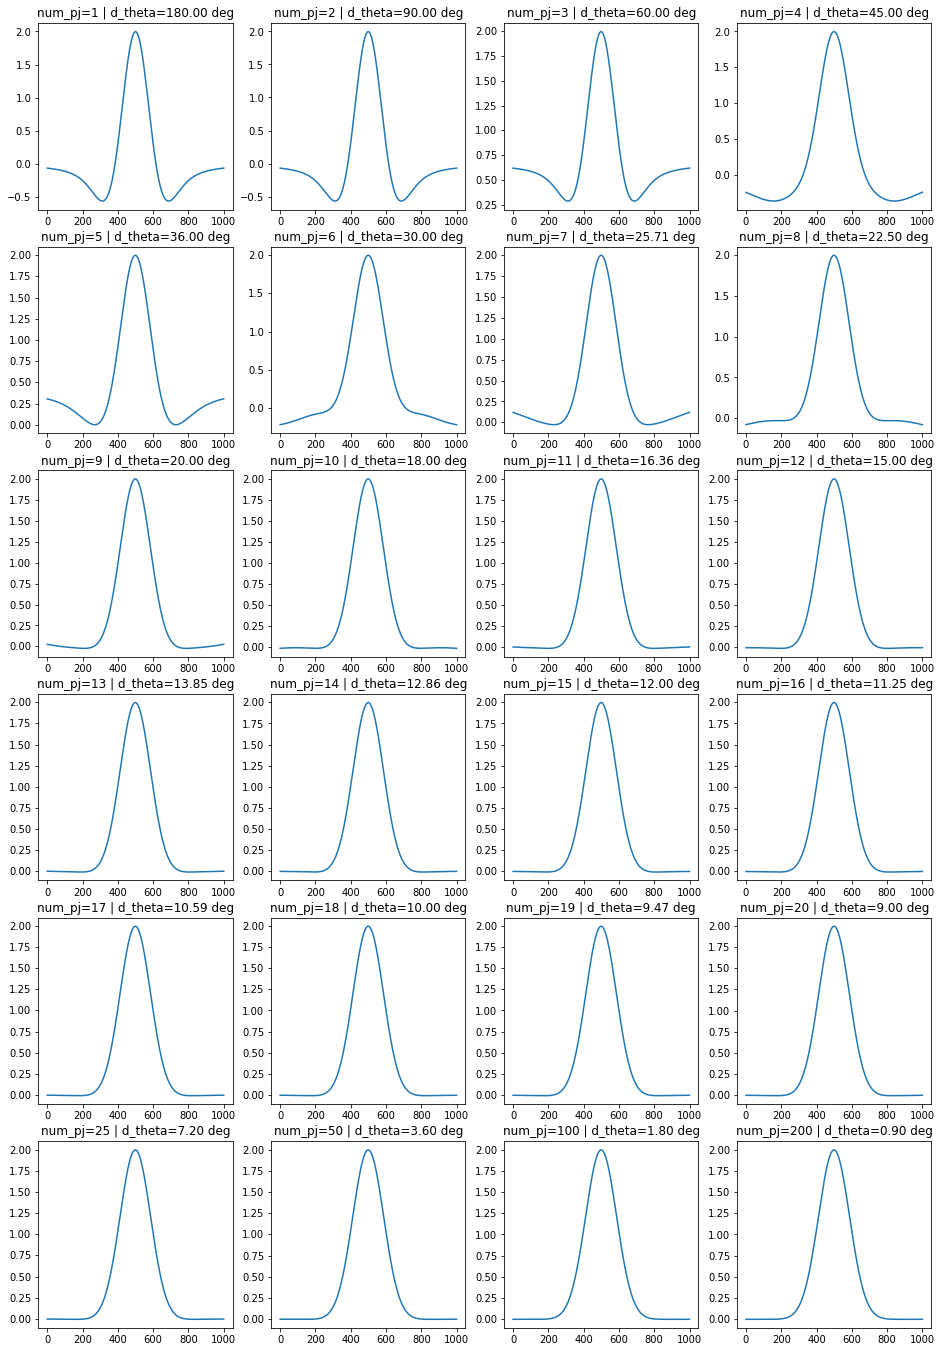

In [237]:
rows = 6
cols = 4
num_pj_list = list(range(1,20+1)) + [25,50,100,200]
fig, axes = plt.subplots(rows, cols,figsize=(16,24)) # r,c
r,c=0,0

for num_pj in num_pj_list:
  d_theta = 180/num_pj
  if r >= rows or c >= cols: break
  Image = back_project(G,num_pj,N=G.shape[0]-1)
  axes[r,c].plot(Image)
  axes[r,c].title.set_text('num_pj=%i | d_theta=%.2f deg' % (num_pj,d_theta))
  c+=1
  if c % cols == 0:
    c=0
    r+=1

  

In [238]:
np.exp(0)

1.0

- The backprojection becomes more accurate as we use a finer grained $\theta$ (and hence more backprojections).
- There is a factor (of 2) unnacounted for somewhere. The 2D Gaussian should have a max of 1 at the origin.

# Example: 2D Gaussian, oval-shaped
- Now symmetry in x and y is broken.
$$
f(x,y) = e^{-ax^2-by^2}
$$
$$ax^2+by^2 = 
(x^\prime)^2[a\cos^2(\theta)+b\sin^2(\theta)] 
+ 
(y^\prime)^2[a\sin^2(\theta)+b\cos^2(\theta)]
+ 2abx^\prime y^\prime [b-a]
$$
- If we complete the square, and do the integral over $y^\prime$, we get
$$F(\theta,x^\prime) = \sqrt{\frac{\pi}{a\sin^2(\theta)+b\cos^2(\theta)}}
\exp -\Big[ 
  (x^\prime)^2[a\cos^2(\theta)+b\sin^2(\theta)]
  + \big( \frac{abx^\prime [a-b]}{a\sin^2(\theta)+b\cos^2(\theta)} \big)^2
\Big]$$
- We can see this gives us back our previous example when $a=b=1$

In [312]:
N=100 # with N=100, can do back projection increments in one degree, but with larger N, need to do more back projections with finer theta increments
X = np.linspace(-2,2,N+1)
theta_n = 180
Theta = np.linspace(0,180,theta_n)
Theta.shape[0]

180

In [0]:
# # calc F
@nb.jit
def compute_F(x,Theta,a=1,b=1):
  theta_n = Theta.shape[0]
  F = np.zeros((theta_n,N+1))
  C0 = np.zeros_like(Theta)
  C1 = np.zeros_like(Theta)
  C2 = a*b*(a-b)*X # C2/2 from C2 in derivation
  for theta_idx in range(Theta.shape[0]):
    theta = Theta[theta_idx]
    C0[theta_idx] = a*np.cos(theta)**2 + b*np.sin(theta)**2
    C1[theta_idx] = a*np.sin(theta)**2 + b*np.cos(theta)**2
  # for x_idx in range(X.shape[0]):
  #   C2[x_idx] = a*b*x*(a-b) 
  for theta_idx in range(Theta.shape[0]):
    for x_idx in range(X.shape[0]):
      F[theta_idx,x_idx] = np.sqrt(np.pi / C1[theta_idx])*np.exp(-X[x_idx]**2*C0[theta_idx]-(C2[x_idx]/C1[theta_idx])**2)
  return(F)


#

In [354]:
F = compute_F(x,Theta,a=2,b=1)
F.shape

(180, 101)

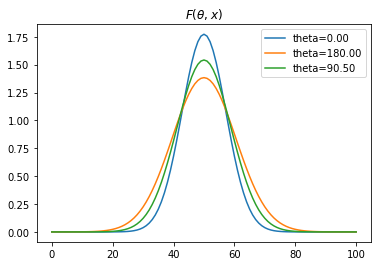

In [359]:
theta_idx=0
pd.Series(F[theta_idx,:]).plot(title=r'$F(\theta,x)$',label='theta=%.2f'%Theta[theta_idx],legend=True) # max sqrt(pi)
theta_idx=-1
pd.Series(F[theta_idx,:]).plot(title=r'$F(\theta,x)$',label='theta=%.2f'%Theta[theta_idx],legend=True) # max sqrt(pi)
theta_idx=int(theta_n/2)
pd.Series(F[theta_idx,:]).plot(title=r'$F(\theta,x)$',label='theta=%.2f'%Theta[theta_idx],legend=True) # max sqrt(pi)

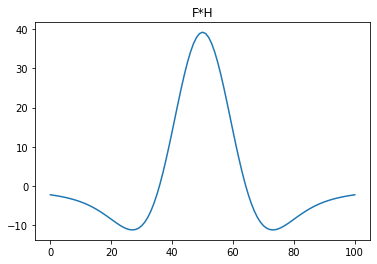

In [360]:
# convolve
# def convolve(F,Hk):
#   G = np.zeros_like(F)
#   for i in range(F.shape[0]):
#     for j in range(F.shape[0]):
#       #if 0 <= i - j and i - j < H_idx_max:
#       G[i]+=F[j]*Hk(i-j) # could precompute H, but then need to map out indeces
#     G[i] /= F.shape[0]
#   return(G)

G = np.zeros_like(F)
for theta_idx in [1]:#range(Theta.shape[0])
  G[theta_idx,:] = convolve(F[theta_idx,:],Hk)
pd.Series(G[theta_idx]).plot(title='F*H')

(101,)
(101,)
(101,)


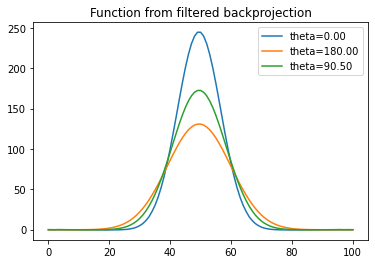

In [363]:
# back project
def back_project(G,num_pj,N):
  Image = np.zeros_like(G)
  N = G.shape[0]
  print(G.shape)
  for j in np.linspace(0,180,num_pj): # degrees
    cj = np.cos(np.pi*j/180)
    #print(cj,)
    for i in range(G.shape[0]):
      x = N/2+(i+1 - N/2)*cj # coordinate offset so origin at N/2
      l = np.ceil(x).astype(np.int32)
      xinterp = x-l
      
      if l <= 1: Image[i] += G[0] #unclear
      elif l >= N: Image[i] += G[-1]
      else:
        Image[i] += G[l-1] + xinterp*(G[l] - G[l-1]) # weights by how close to neighbouring points
  Image *= np.pi/num_pj
  return(Image)

Images = np.zeros_like(G)
theta_idx=0
num_pj=50
Images[theta_idx] = back_project(convolve(F[theta_idx,:],Hk),num_pj = num_pj,N=G.shape[0]-1)
pd.Series(Images[theta_idx]).plot(title='Function from filtered backprojection', label='theta=%.2f' % Theta[theta_idx],legend=True)

theta_idx=-1
Images[theta_idx] = back_project(convolve(F[theta_idx,:],Hk),num_pj = num_pj,N=G.shape[0]-1)
pd.Series(Images[theta_idx]).plot(title='Function from filtered backprojection', label='theta=%.2f' % Theta[theta_idx],legend=True)

theta_idx=int(theta_n/2)
Images[theta_idx] = back_project(convolve(F[theta_idx,:],Hk),num_pj = num_pj,N=G.shape[0]-1)
pd.Series(Images[theta_idx]).plot(title='Function from filtered backprojection', label='theta=%.2f' % Theta[theta_idx],legend=True)

The trend in there, but the normalization is different than the function $f(x,y)$.

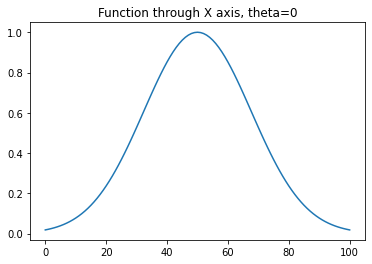

In [368]:
Y=0
pd.Series(np.exp(-a*X**2-b*Y**2)).plot(title='Function through X axis, theta=0')